In [37]:
# Initial imports
import pandas as pd

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Stats testing
from scipy.stats import pearsonr

# Modeling
from statsmodels.tsa.api import Holt, ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Project specific imports
import wrangle
import explore
import model

# Utility imports
import sys
import os
home_directory_path = os.path.expanduser('~')
sys.path.append(home_directory_path +'/utils')
import wrangle_utils as w
import explore_utils as e
import model_utils as m
import env

# Turn off warnings
import warnings
warnings.filterwarnings("ignore")

#
# Project Overview:
## The superstore sales project aims to create a model for predicting the companies overall sales volume over the next quarter of operation using time-series analysis. This data was acquired from Kaggle.com

# 
# Wrangle

In [2]:
# Bring in the data
df = wrangle.wrangle_superstore()

In [3]:
# Perform a 70/15/15 split on the dataframe
train, validate, test = wrangle.split_superstore(df)

 Train shape: (6990, 10)
 Validate shape: (1504, 10)
 Test shape (1500, 10)


#
# Explore
- General exploration
- Time exploration

## General exploration:
- Finding relationships between features and sales

## Initial questions:
- What are the highest selling regions?
- What are the highest selling states?
- What are the highest selling segments?
- What are the highest selling categories?

## Question 1:
- What are the highest selling regions?

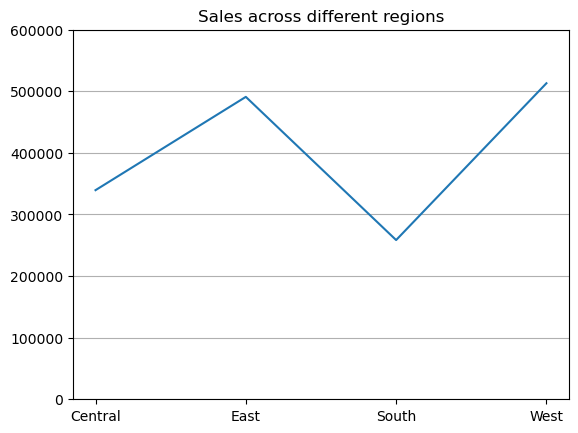

In [4]:
# Plot the sales across different regions
plt.plot(train.groupby('region').sales.agg('sum'))
plt.ylim(0, 600_000);
plt.grid(axis='y')
plt.title('Sales across different regions');

### Observations: 
- The south brings in about half as many sales as the west

## Question 2:
- What are the highest selling states?

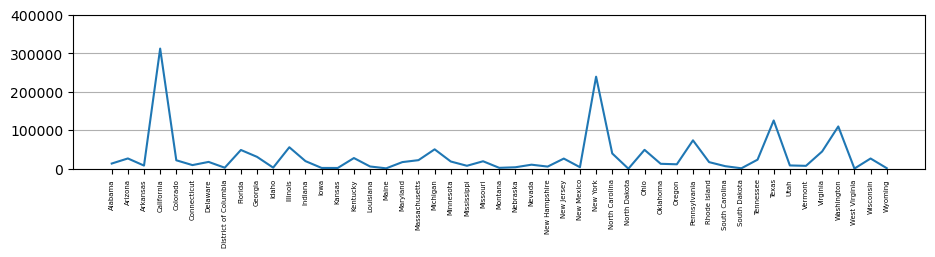

In [5]:
# Plot the sales across different states
plt.figure(figsize=(11,2))
plt.plot(train.groupby('state').sales.agg('sum'))
plt.ylim(0, 400_000)
plt.xticks(fontsize=5,rotation=90);
plt.grid(axis='y')

### Observations: 
- the highest selling states are California (330k), New York (200k), Texas (110k), and Washington (100k)

## Question 3:
- What are the highest selling segments?

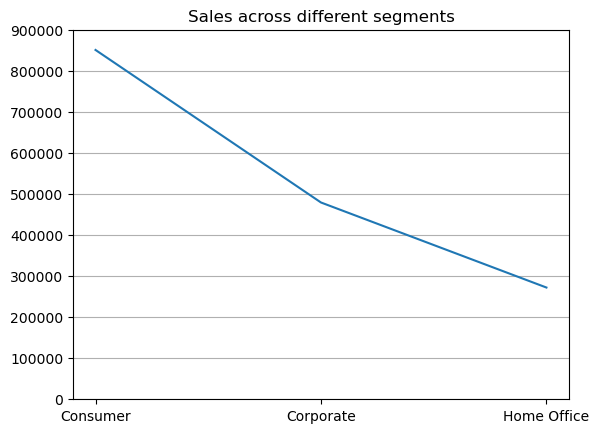

In [6]:
# Plot the sales across different segments
plt.plot(train.groupby('segment').sales.agg('sum'))
plt.ylim(0, 900_000);
plt.grid(axis='y')
plt.title('Sales across different segments');

### Observations: 
- the consumer category brings in much more (800,000) than corporate (500,000), which brings in more than home office (300,000)

## Question 4:
- What are the highest selling categories?

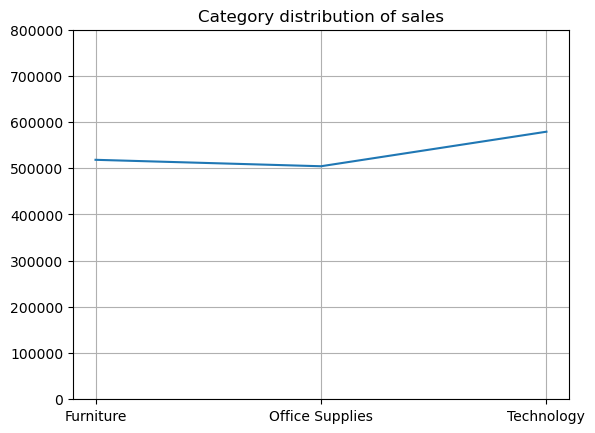

In [7]:
plt.plot(train[['category', 'sales']].groupby('category').sales.agg('sum'))
plt.grid('y')
plt.ylim(0, 800_000)
plt.title(f'Category distribution of sales');

### Observations:
- Each category produces a similar amount of sales

# 
## General Explore Summary: 
- The south region produces about half as many sales as the west region
- the highest selling states are California (330k), New York (200k), Texas (110k), and Washington (100k)
- the consumer category produces many more sales (800,000) than corporate (500,000), which produces more than home office (300,000)
- Each category produces a similar amount of sales

### Additional Notes:
- During feature engineering dummy columns of category, region, and segment were created and aggregated by mean over a weekly and monthly timescale then evaluated for correlation with sales. It was determined that none of these aggregations correlated with the sales volume

#
## Time exploration:
- Finding patterns in sales volume over time


train length: 1166
validate length: 145
test length: 147
    


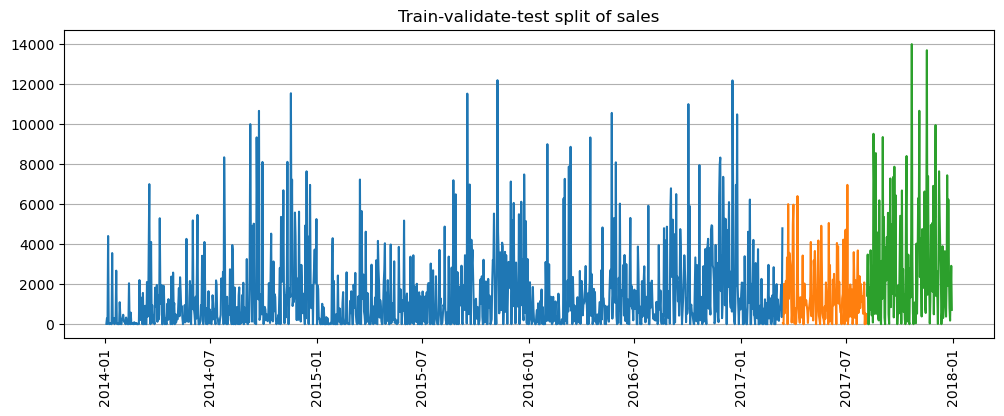

In [8]:
# Bring in the data, prepare, and split into train, validate, and test
train, validate, test = explore.time_wrangle_superstore(df, 'Train-validate-test split of sales')

### Weekly resampling was chosen as a balance between having adequate training data and having a stronger seasonality pattern

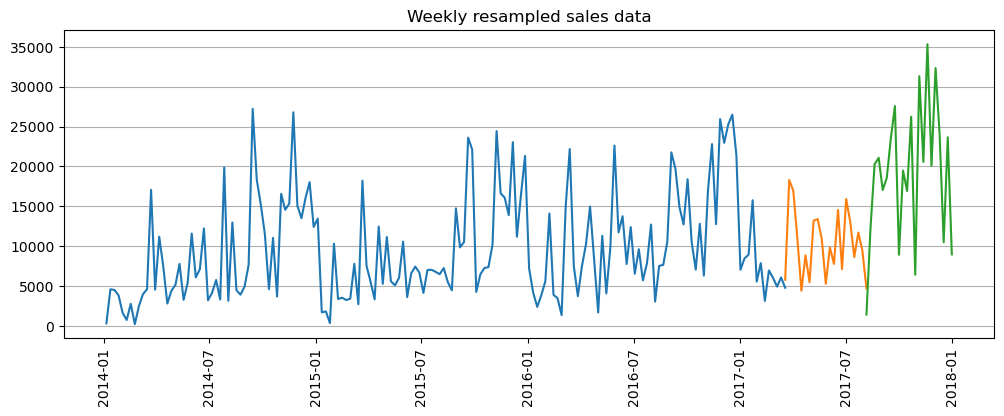


train length: 168
validate length: 21
test length: 22
    


In [9]:
# resample train, validate, test on a weekly scale
train, validate, test = explore.weekly_resample(train, validate, test)

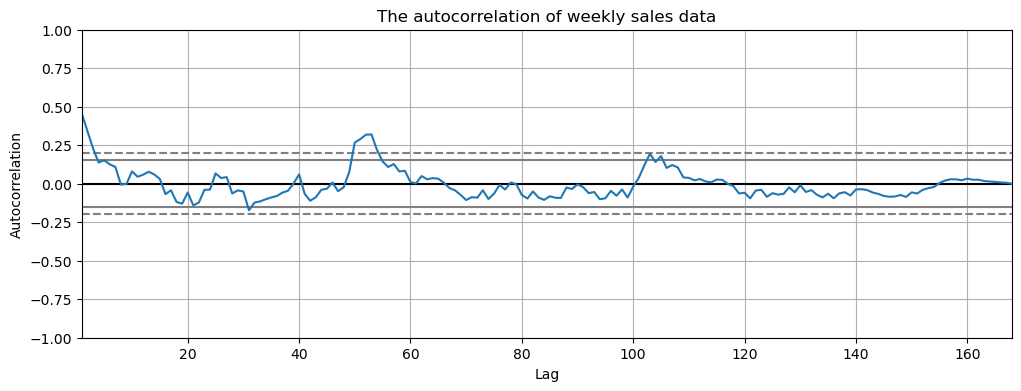

In [10]:
explore.plot_autocorrelation(train)

### Observations:
- Weekly sampled sales data dsplays reasonably strong autocorrelation at around 52 weeks of lag
- Using the peak around 105 weeks of lag may add predictive value to a model, however so much data would have to be dropped to handle the resulting nulls that this wouldn't be feasible without anouther few years of data

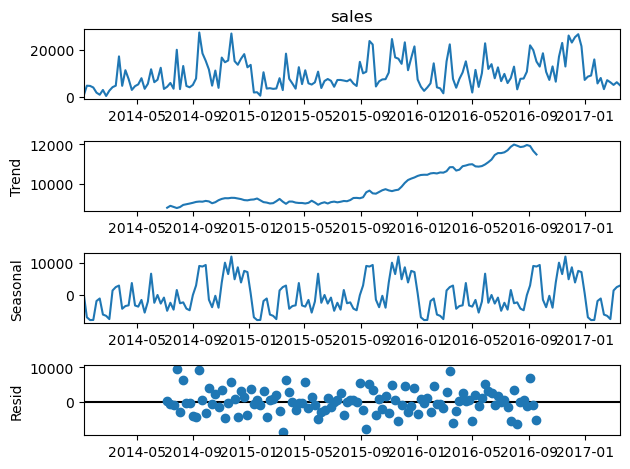

In [11]:
explore.seasonal_decomposition(train)

### Observation:
- Weekly sampled sales data displays clear seasonality

### Stats testing lag values

In [12]:
explore.test_lag_values(train)

,lag,R value,P-value
0,50,0.410325,3.936251e-06
1,51,0.444784,5.055809e-07
2,52,0.488315,2.687441e-08
3,53,0.490492,2.628794e-08
4,54,0.349429,1.386257e-04


### Observation:
- A lag of 53 weeks produces the highest correlation to the target and is statistically valid (R = .49, P-value = 2.63e-08)
- This lag feature will be created and used to train a regression model

### Create the 53 week lag column


train length: 124
validate length: 15
test length: 17
    


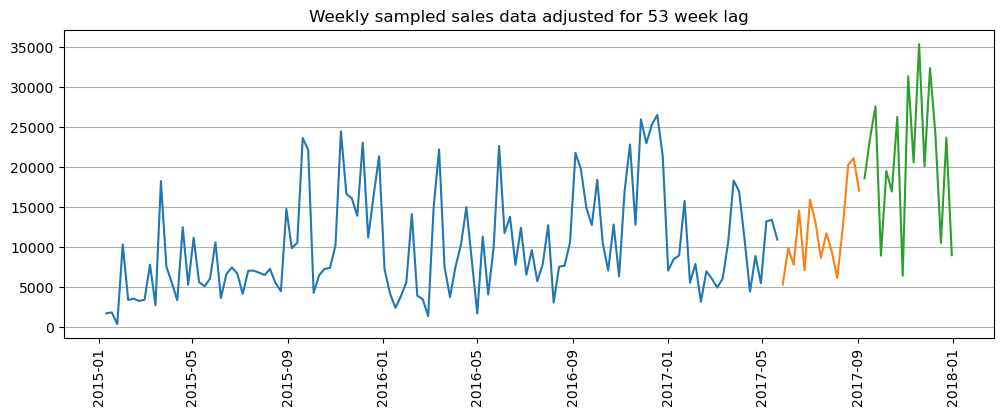

In [13]:
train, validate, test = explore.time_wrangle_superstore_w_lag()

## Time explore summary:
#### Autocorrelation
- Weekly sampled sales data displays reasonably strong autocorrelation at around 52 weeks of lag (R ~.5)
- Using the peak around 105 weeks of lag may add predictive value to a model, however so much data would have to be dropped to handle the resulting nulls that this wouldn't be feasible without anouther few years of data
#### Seasonality
- Weekly sampled sales data displays clear seasonality
#### Lag
- A lag of 53 weeks produces the highest correlation to the target and is statistically valid (R = .49, P-value = 2.63e-08

#
# Model
- Build baseline models and evaluate for rmse
- Build non-baseline models and evaluate against the bst performing baseline

## Rolling Average model - baseline

#### Last Observed Value, Simple Average, and Rolling Average baseline models were all evaluated for rmse performance and the Rolling Average model with a period of 47 days was determined to perform the best.

Period = 47 weeks



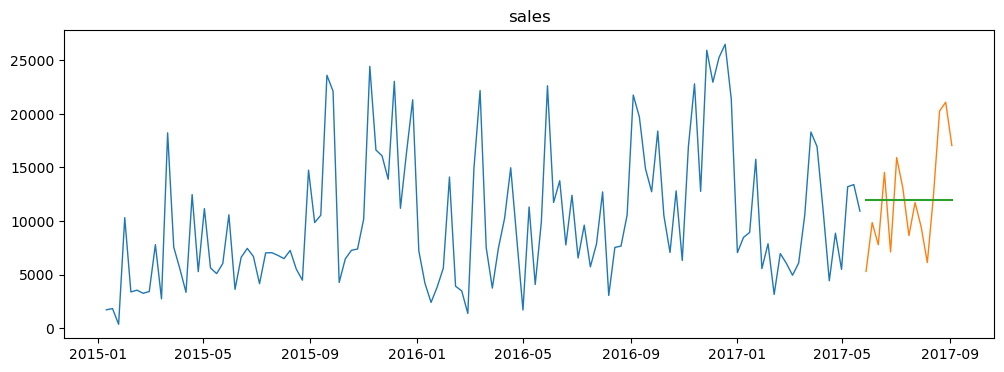

sales -- RMSE: 4785


In [28]:
rolling_sales = round(train['sales'].rolling(47).mean()[-1], 2)

yhat_df = pd.DataFrame({'sales': rolling_sales},
                             index=validate.index)

# Plot 47 week rolling average
print(f'Period = 47 weeks\n')
rmse = model.plot_and_eval(train, validate, yhat_df, 'sales')

rmse_df = pd.DataFrame({
'model': 'RollingAverage_47',
'rmse' : round(rmse)
}, index=[0])

### Observation:
- A Rolling Average model with a period of 47 days performs best with an rmse of 4785

## Holt's Linear model

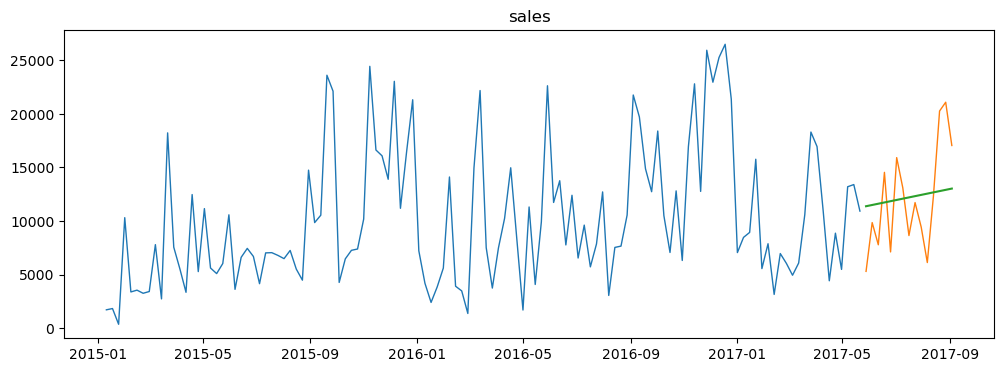

sales -- RMSE: 4502


In [31]:
holt_model = Holt(train.sales, exponential=False, damped=False)
holt_model = holt_model.fit(optimized=True)
yhat_values = holt_model.predict(start = validate.index[0],
                              end = validate.index[-1])
yhat_df['sales'] = round(yhat_values, 2)

rmse = model.plot_and_eval(train, validate, yhat_df, 'sales')
    
rmse_df = rmse_df.append({
'model': 'HoltsLinear',
'rmse' : round(rmse)
}, ignore_index=True)

## Modeling results on validate

In [32]:
rmse_df

,model,rmse
0,RollingAverage_47,4785
1,HoltsLinear,4502


## Observation:
- The Holt's Linear model outperformed baseline by 283 sales, or 6%

## Evaluate Holt's Linear model on the test data

### First, evaluate the baseline model performance

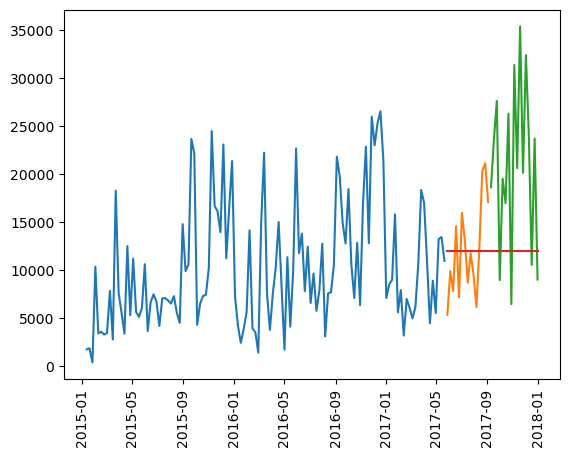

In [41]:
rolling_sales = round(train['sales'].rolling(47).mean()[-1], 2)

yhat_df = pd.DataFrame({'sales': rolling_sales},
                             index=pd.concat([validate, test]).index)
# Plot 30 week rolling average

plt.plot(train.sales)
plt.plot(validate.sales)
plt.plot(test.sales)
plt.plot(yhat_df)
plt.xticks(rotation=90);

rmse = mean_squared_error(yhat_df, pd.concat([validate.sales, test.sales]))**.5

results_df = pd.DataFrame({
'model': 'TrainRollingAverage_47',
'rmse' : round(rmse)
}, index=[0])

### Now, evaluate Holt's Linear model

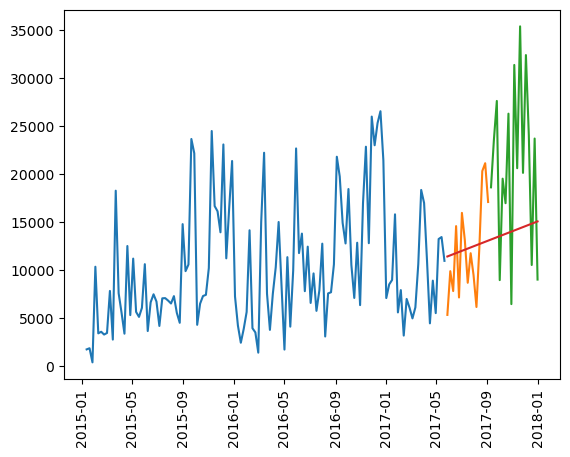

In [43]:
yhat_values = holt_model.predict(start = validate.index[0],
                              end = test.index[-1])
yhat_df.pred_sales = round(yhat_values, 2)

rmse = round((mean_squared_error(pd.concat([validate.sales, test.sales]), yhat_df.pred_sales)**.5 ), 0)
    bb
plt.plot(train.sales)
plt.plot(validate.sales)
plt.plot(test.sales)
plt.plot(yhat_df.pred_sales)
plt.xticks(rotation=90)
    
results_df = results_df.append(pd.DataFrame({
'model': 'HoltsLinear',
'rmse' : round(rmse)
}, index=[0]))

## Results

In [44]:
results_df

,model,rmse
0,TrainRollingAverage_47,9437
0,HoltsLinear,8410


## Modeling summary
- Holt's Linear model outperformed the Rolling Average model with a period of 47 days by 1027 dollars in rmse, or 11%

#
# Project Summary


## General Explore Summary: 
- The south region produces about half as many sales as the west region
- the highest selling states are California (330k), New York (200k), Texas (110k), and Washington (100k)
- the consumer category produces many more sales (800,000) than corporate (500,000), which produces more than home office (300,000)
- Each category produces a similar amount of sales

#### Additional Notes:
- During feature engineering dummy columns of category, region, and segment were created and aggregated by mean over a weekly and monthly timescale then evaluated for correlation with sales. It was determined that none of these aggregations correlated with the sales volume

## Time explore summary:
#### Autocorrelation
- Weekly sampled sales data displays reasonably strong autocorrelation at around 52 weeks of lag (R ~.5)
- Using the peak around 105 weeks of lag may add predictive value to a model, however so much data would have to be dropped to handle the resulting nulls that this wouldn't be feasible without anouther few years of data
#### Seasonality
- Weekly sampled sales data displays clear seasonality
#### Lag
- A lag of 53 weeks produces the highest correlation to the target and is statistically valid (R = .49, P-value = 2.63e-08

## Modeling summary:
- Holt's Linear model outperformed the Rolling Average model with a period of 47 days by 1027 dollars in rmse, or 11%

#
# Conclusion

#
# Recommendations

#
# Next Steps